By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook details how to use a pre-trained model to predict antibody binding affinity with ANTIPASTI.

In [69]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading a test sample

In [294]:
modes = 30
n_filters = 3
filter_size = 5
pooling_size = 2
n_max_epochs = 495

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'paired_hl'
test_pdb = '4yhi'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, mode=mode, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb)
input_shape = preprocessed_data.test_x.shape[-1]

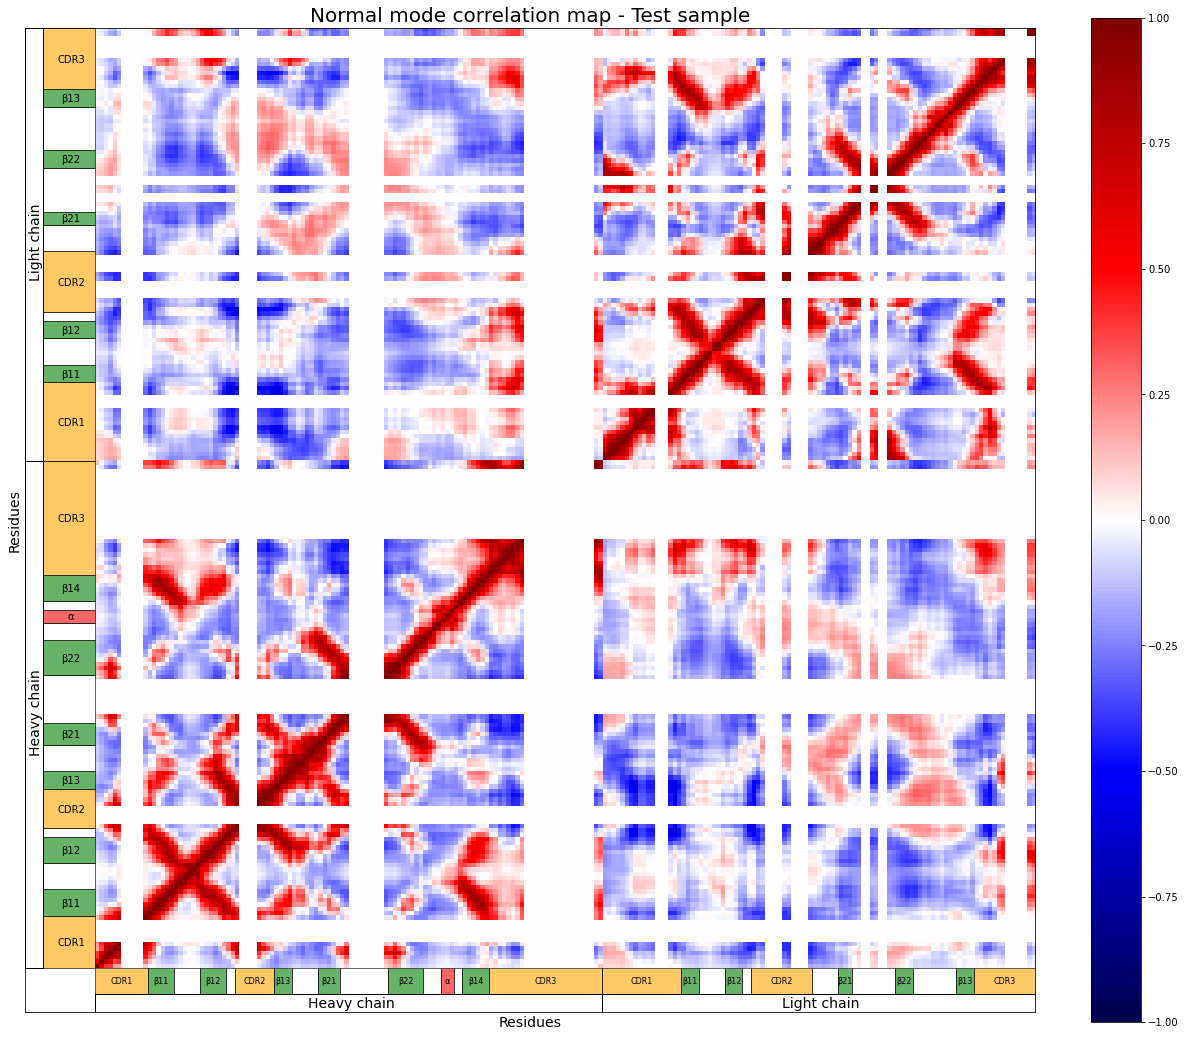

In [295]:
plot_map_with_regions(preprocessed_data, preprocessed_data.test_x, 'Normal mode correlation map - Test sample')

# Loading an ANTIPASTI checkpoint

In [296]:
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model,_,_,train_losses, test_losses = load_checkpoint(path, input_shape)
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=33075, out_features=1, bias=False)
)

# Predicting the binding affinity

In [297]:
# We convert to the torch format
test_sample = torch.from_numpy(preprocessed_data.test_x.reshape(1, 1, input_shape, input_shape).astype(np.float32))

print('The output value is ' + str(model(test_sample)[0].detach().numpy()[0,0]))
print('So the binding affinity is ' + str(10**model(test_sample)[0].detach().numpy()[0,0]))

The output value is -9.710014
So the binding affinity is 1.9497802041215675e-10
